In [9]:
import time, pickle, re, sys, os, jsonlines, random, collections, math, omegaconf
import ujson as json
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from copy import deepcopy
from multiprocessing.pool import ThreadPool
from functools import partial
from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
import scipy

# import GPUtil

# gpu_id = '2' #'1'
# os.environ['CUDA_VISIBLE_DEVICES']=gpu_id       # do before importing torch

from einops import rearrange
import torch
from torch import nn
import torch.nn.functional as F

from sklearn.metrics import f1_score, roc_auc_score, balanced_accuracy_score, confusion_matrix

In [8]:
# !find ../../../../outputs/2022-10-16/ -maxdepth 4 -name "*u9juwk8k*" -print  # dlr 256
# !find ../../../../outputs/2022-11-05/ -maxdepth 4 -name "*1n38ah1m*" -print  # dlr 256
# !find ../../../../outputs/2022-11-08/ -maxdepth 4 -name "*2ntxt62w*" -print  # dlr 256
# !find ../../../../outputs/2022-11-21/ -maxdepth 4 -name "*1fnfm725*" -print  # dlr 256
!find ../../../../outputs/2022-11-25/ -maxdepth 4 -name "*2bmxof9u*" -print    # dlr 512

# !ls ../../../../outputs/2022-10-07/13-05-47/checkpoints/val/

../../../../outputs/2022-11-25/15-50-05/wandb/run-20221125_155308-2bmxof9u
../../../../outputs/2022-11-25/15-50-05/wandb/run-20221125_155308-2bmxof9u/run-2bmxof9u.wandb


# Pathfinder with path supervision

In [2]:
# create mask for two main paths

def get_output_mask(d):
    [origin_mark_idx, terminal_mark_idx] = d['marker_indices']

    paths = []
    for i, path_inds in enumerate(d['segs']):
        path = np.zeros(d['image_size'], dtype=np.uint8)
        path[path_inds] = 1 + (origin_mark_idx == terminal_mark_idx == i)
        paths.append(path)
    # pixel label:  0 not on a main path, 1 on some main path but not any connecting path, 2 on a connecting path 
    return torch.LongTensor(np.maximum(*paths))

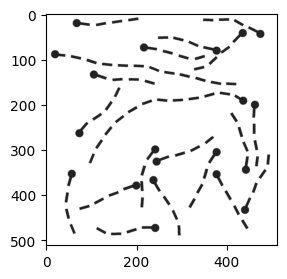

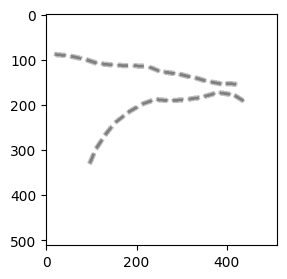

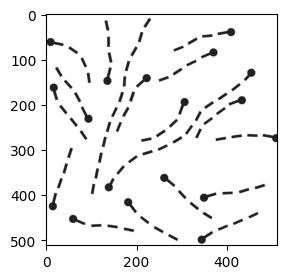

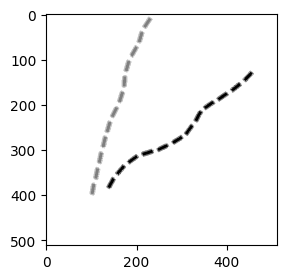

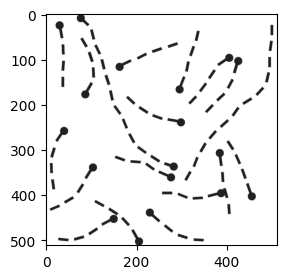

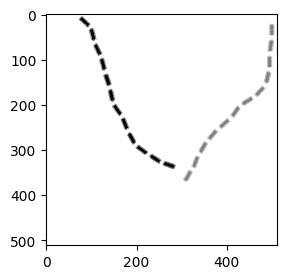

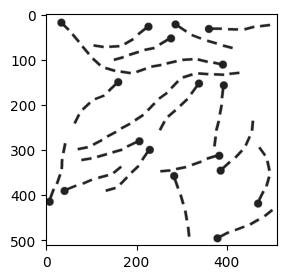

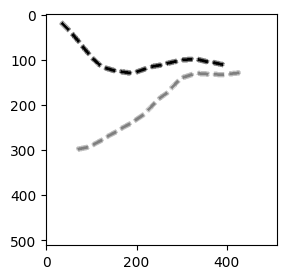

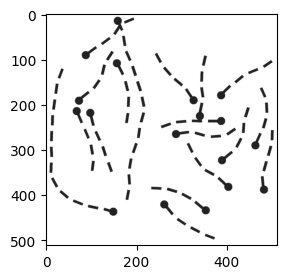

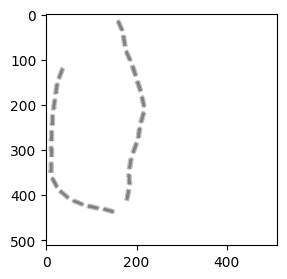

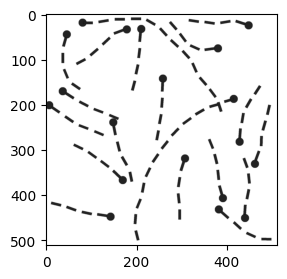

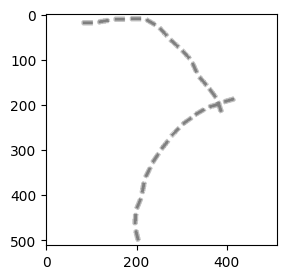

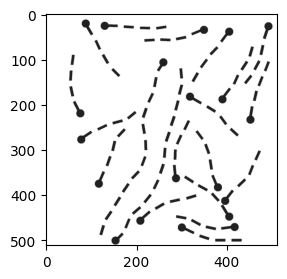

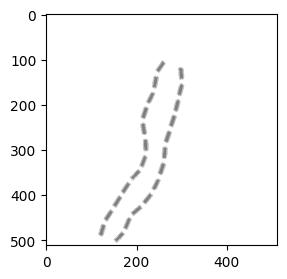

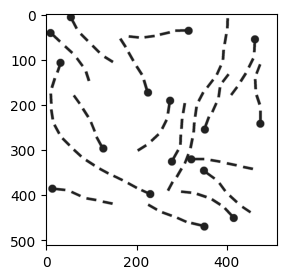

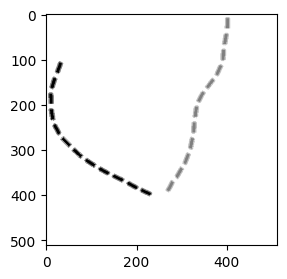

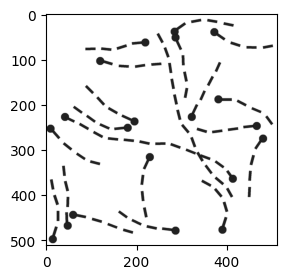

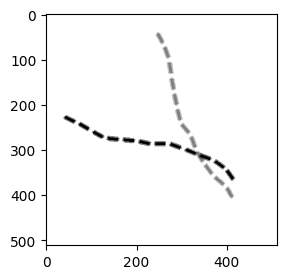

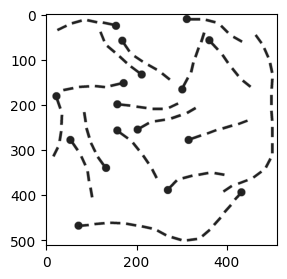

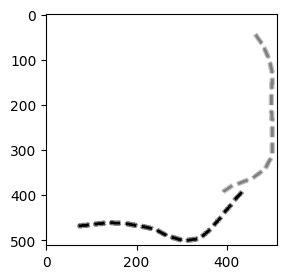

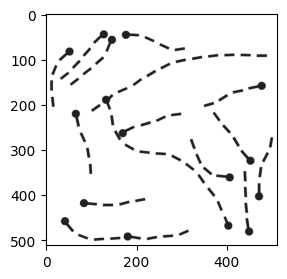

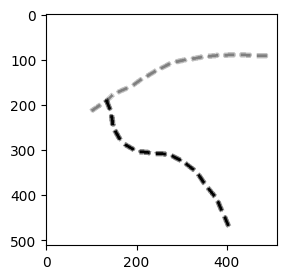

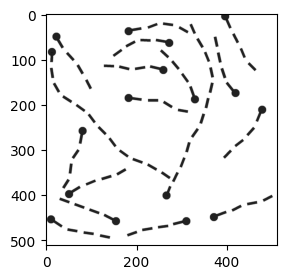

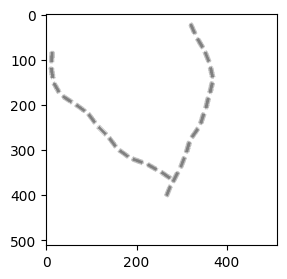

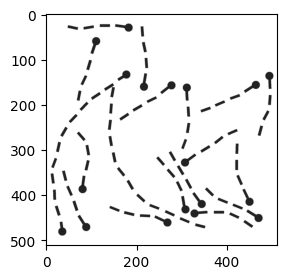

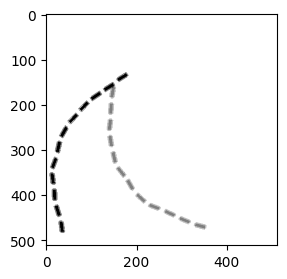

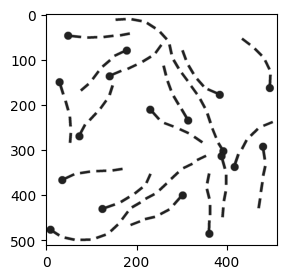

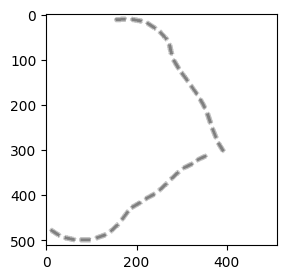

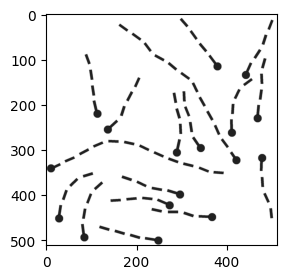

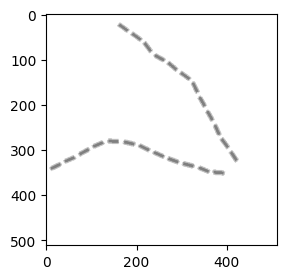

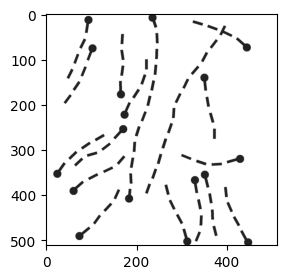

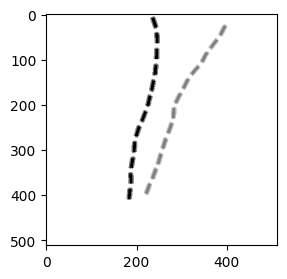

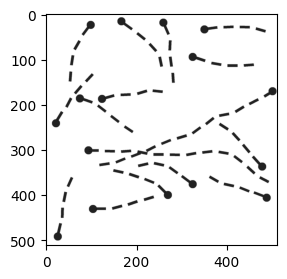

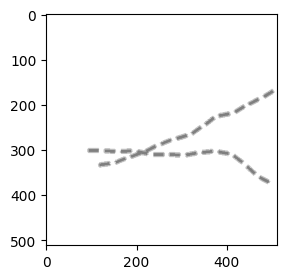

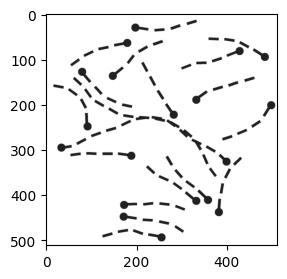

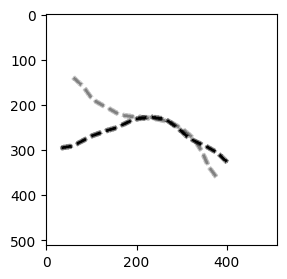

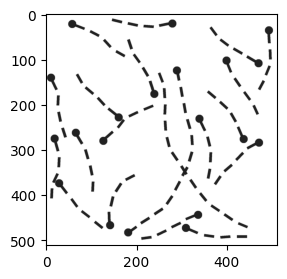

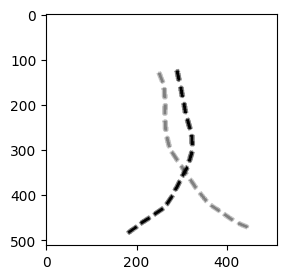

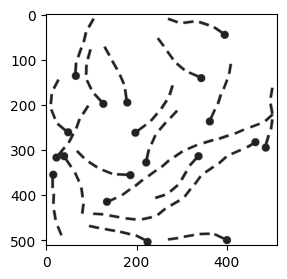

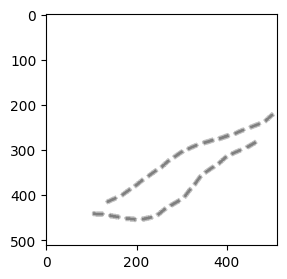

In [5]:
# direc = './data/pathfinder256_segmentation'
direc = '../../../../data/pathfinder_segmentation/pathfinder512_segmentation/'
for i in range(20):
    with open(f'{direc}/imgs/0/sample_{i}.png', "rb") as f:
        sample = np.array(Image.open(f).convert("L"))  # Open in grayscale
    plt.figure(figsize=(3,3))
    plt.imshow(sample, cmap='binary')
    plt.show()
    
    main_segs = pickle.load(open(f"{direc}/paths/0/sample_{i}.pkl",'rb'))
    # seg0, seg1 = main_segs['segs']
    # sample[seg0] = 0
    # sample[seg1] = 0
    plt.figure(figsize=(3,3))
    # plt.imshow(sample, cmap='binary')
    plt.imshow(get_output_mask(main_segs), cmap='binary', vmin=0, vmax=2)
    plt.show()

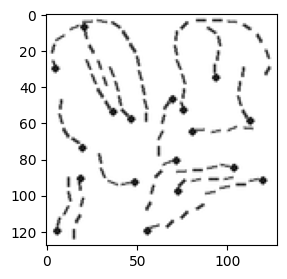

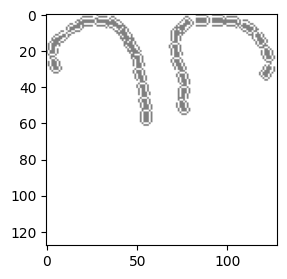

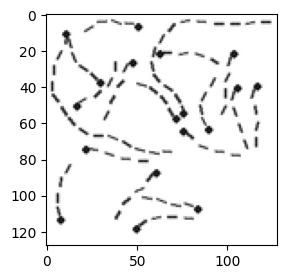

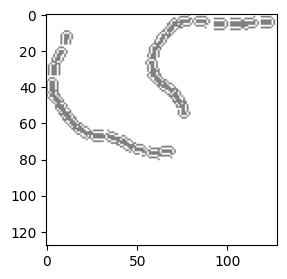

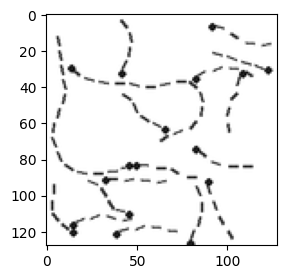

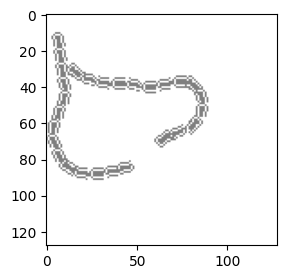

FileNotFoundError: [Errno 2] No such file or directory: './_data/pathfinder128_segmentation/imgs/0/sample_3.png'

In [120]:
direc = './_data/pathfinder128_segmentation'
for i in range(20):
    with open(f'{direc}/imgs/0/sample_{i}.png', "rb") as f:
        sample = np.array(Image.open(f).convert("L"))  # Open in grayscale
    plt.figure(figsize=(3,3))
    plt.imshow(sample, cmap='binary')
    plt.show()
    
    main_segs = pickle.load(open(f"{direc}/paths/0/sample_{i}.pkl",'rb'))
    # seg0, seg1 = main_segs['segs']
    # sample[seg0] = 0
    # sample[seg1] = 0
    plt.figure(figsize=(3,3))
    # plt.imshow(sample, cmap='binary')
    plt.imshow(get_output_mask(main_segs), cmap='binary', vmin=0, vmax=2)
    plt.show()

In [18]:
direc = '../../../../data/pathfinder/pathfinder128/curv_contour_length_14/'
metadata_file = direc  + '/metadata/0.npy'
a = set()
with open(metadata_file, "r") as f:
    for metadata in f.read().splitlines():
        metadata = metadata.split()
        a.add(' '.join(metadata[4:]))
        # image_path = Path(diff_level) / metadata[0] / metadata[1]
        # print(metadata)
        # break
a

{'1.8 14 4.666666666666667 5 1.5 2 1', '1.8 14 4.666666666666667 5 1.5 3 1'}

In [ ]:
for i in range(10):
    with open(direc + f'/imgs/0/sample_{i}.png', "rb") as f:
        sample = Image.open(f).convert("L")  # Open in grayscale
    print(np.max(sample))
    plt.figure(figsize=(3,3))
    plt.imshow(sample, cmap='binary')
    plt.show()

In [3]:
from collections import Counter

direc = '../../../../data/pathfinder_segmentation/pathfinder256_segmentation/'
a = Counter()
for i in range(30):
    metadata_file = direc  + f'/metadata/{i}.npy'
    # a = Counter()
    for metadata in np.load(metadata_file).tolist():
        a.update({metadata[3]})
        # break
    print(i, a, sum(a.values()))

0 Counter({'0': 2526, '1': 2474}) 5000
1 Counter({'0': 5014, '1': 4986}) 10000
2 Counter({'0': 7572, '1': 7428}) 15000
3 Counter({'0': 10085, '1': 9915}) 20000
4 Counter({'0': 12608, '1': 12392}) 25000
5 Counter({'0': 15092, '1': 14908}) 30000
6 Counter({'0': 17503, '1': 17497}) 35000
7 Counter({'0': 20011, '1': 19989}) 40000
8 Counter({'1': 22501, '0': 22499}) 45000
9 Counter({'0': 25009, '1': 24991}) 50000
10 Counter({'0': 27530, '1': 27470}) 55000
11 Counter({'0': 30072, '1': 29928}) 60000
12 Counter({'0': 32593, '1': 32407}) 65000
13 Counter({'0': 35096, '1': 34904}) 70000
14 Counter({'0': 37612, '1': 37388}) 75000
15 Counter({'0': 40141, '1': 39859}) 80000
16 Counter({'0': 42712, '1': 42288}) 85000
17 Counter({'0': 45238, '1': 44762}) 90000
18 Counter({'0': 47772, '1': 47228}) 95000
19 Counter({'0': 50297, '1': 49703}) 100000


FileNotFoundError: [Errno 2] No such file or directory: '../../../../data/pathfinder_segmentation/pathfinder256_segmentation//metadata/20.npy'

In [ ]:
or file in os.listdir(direc)[15:35]:
    outs = torch.load(direc+ file, map_location='cpu')

In [19]:
# direc = '../../../../outputs/2022-10-04/14-08-33/val_outputs'
# outs = torch.load(direc+ '/cuda:0_4_0.pt', map_location='cpu')

# direc = '../../../../outputs/2022-10-12/13-23-09/val_outputs/'    # f1 94
# direc = '../../../../outputs/2022-10-16/10-19-01/val_outputs/'    # f1 94
# direc = '../../../../outputs/2022-10-19/09-17-41/val_outputs/'    # f1 93.6  dlr 256
# direc = '../../../../outputs/2022-11-07/08-52-48/val_outputs/'    # f1 69 dlr 512
# direc = '../../../../outputs/2022-11-08/08-30-11/val_outputs/'    # f1 71 dlr 512
# direc = '../../../../outputs/2022-11-10/14-00-20/val_outputs/'    # f1 69/89 dlr 512
direc = '../../../../outputs/2022-11-28/13-11-36/val_outputs/'    # f1 69/89 dlr 512

y_pred, y_true = [], []
for file in os.listdir(direc)[15:35]:
    outs = torch.load(direc+ file, map_location='cpu')
    preds = rearrange(outs[0].argmax(-1), 'b (h w) -> b h w', h=int(outs[0].shape[1]**.5))
    mask = rearrange(outs[1], 'b (h w) -> b h w', h=int(outs[1].shape[-1]**.5))
    print(preds.shape, mask.shape)
    y_pred.append(preds); y_true.append(mask);
    
    # for i in range(len(mask)):
    #     plt.figure(figsize=(3,3))
    #     f, axs = plt.subplots(1,2)
    #     axs[0].imshow(preds[i], cmap='binary', vmin=0, vmax=2)
    #     axs[0].set_title('pred')
    #     axs[1].imshow(mask[i], cmap='binary', vmin=0, vmax=2)
    #     axs[1].set_title('true')
        
y_pred, y_true = map(torch.cat, (y_pred, y_true))
y_pred.shape, y_true.shape

torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([2, 512, 512]) torch.Size([2, 512, 512])
torch.Size([

(torch.Size([40, 512, 512]), torch.Size([40, 512, 512]))

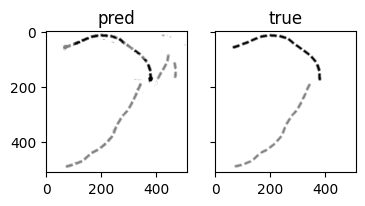

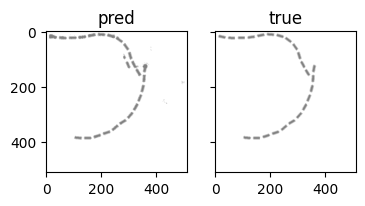

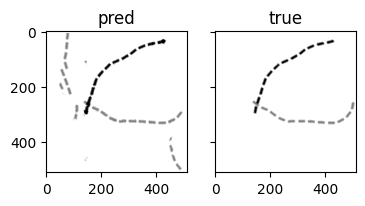

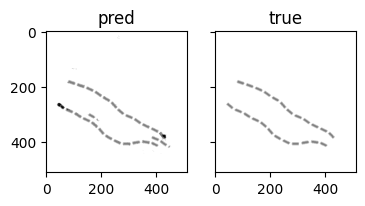

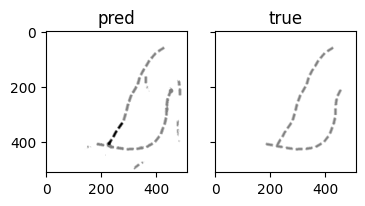

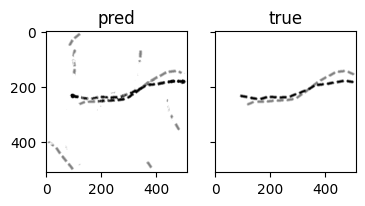

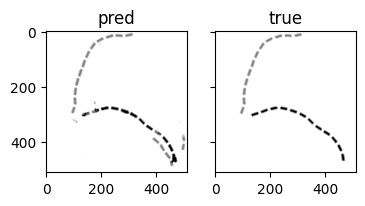

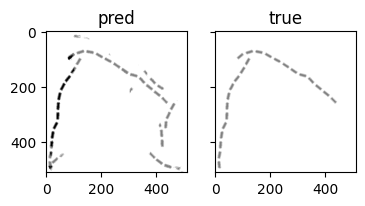

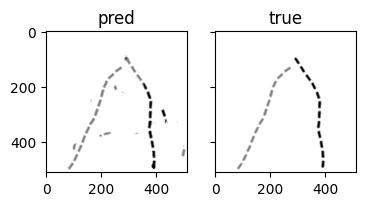

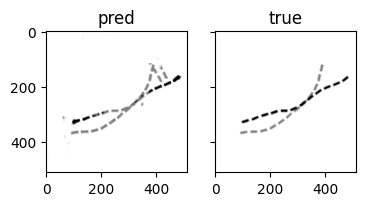

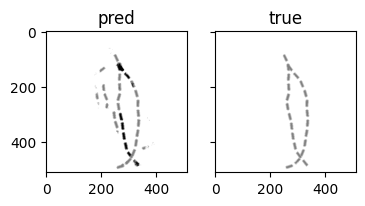

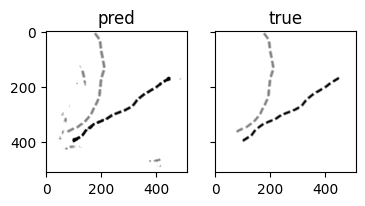

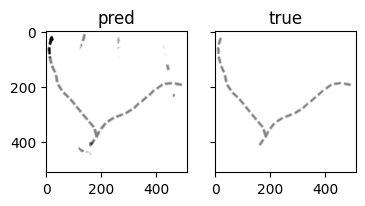

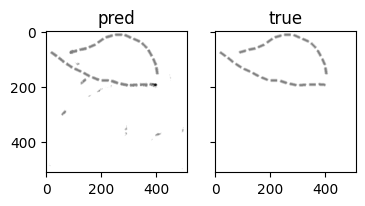

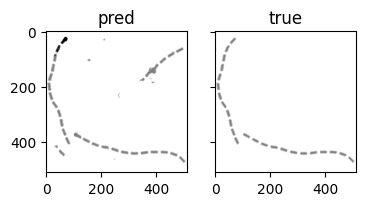

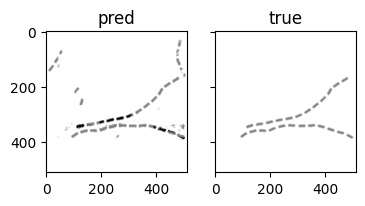

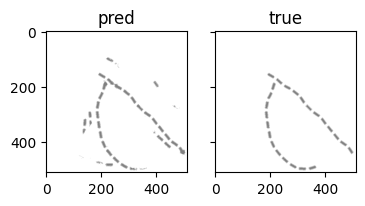

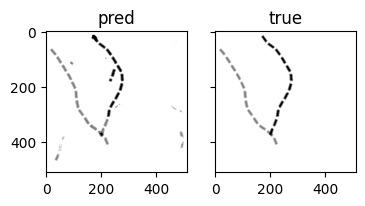

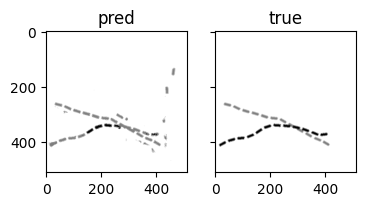

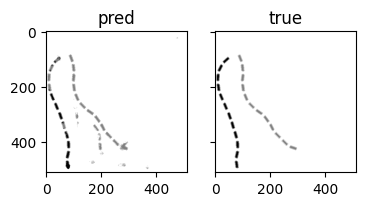

In [22]:
for i in range(0,20):
    f, axs = plt.subplots(1,2, figsize=(4,4), sharey=True)
    axs[0].imshow(y_pred[i], cmap='binary', vmin=0, vmax=2)
    axs[0].set_title('pred')
    axs[1].imshow(y_true[i], cmap='binary', vmin=0, vmax=2)
    axs[1].set_title('true')
    axs[1].set_title('true')

In [17]:
confusion_matrix(y_true.view(-1), y_pred.view(-1))

array([[38212897,    42620,    11577],
       [    3633,   756268,    23472],
       [     285,    22294,   248554]])

In [18]:
f1_score(y_true.view(-1), y_pred.view(-1), average=None)

array([0.99924017, 0.94265139, 0.89611635])

In [20]:
balanced_accuracy_score(y_true.view(-1), y_pred.view(-1))

0.9598161034068813

In [21]:
balanced_accuracy_score(y_true.view(-1), y_pred.view(-1), adjusted=True)

0.9397241551103219

In [69]:
balanced_accuracy_score(y_true.view(-1), 0*y_pred.view(-1))

0.3333333333333333

In [14]:
np.mean([0.99844305, 0.90660858, 0.90365926])

0.9362369633333333

In [59]:
y_true[i].dtype

torch.int64

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(10,3))#, constrained_layout=True)
fig.tight_layout()

for col, i in enumerate([0,2,7,15,1,12,18,16]):
    ax[0, col].imshow(y_true[i], cmap='binary', vmin=0, vmax=2)
    ax[0, col].set_xticks([])
    if col > 0:
        ax[0, col].set_yticks([])
    
    ax[1, col].imshow(y_pred[i], cmap='binary', vmin=0, vmax=2)
    ax[1, col].set_xticks([])
    ax[1, col].set_yticks([])
    
fig.subplots_adjust(wspace=0., hspace=0.001)
# plt.savefig('../../../../misc/plots/pathfinder_segmentation_256_dlr_preds.pdf', bbox_inches='tight')

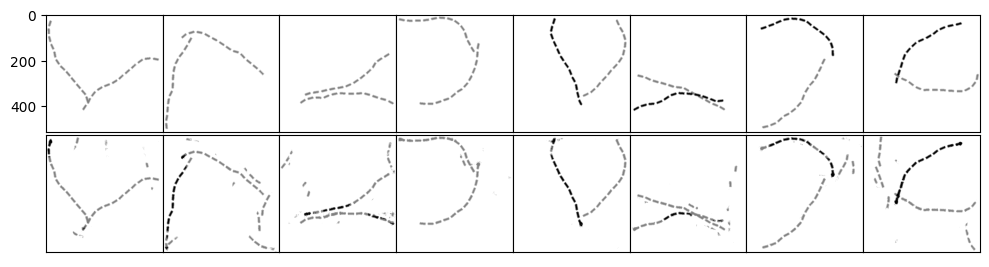

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(10,3))#, constrained_layout=True)
fig.tight_layout()

for col, i in enumerate([12,7,15,1,20,18,0,2]):
    ax[0, col].imshow(y_true[i], cmap='binary', vmin=0, vmax=2)
    ax[0, col].set_xticks([])
    if col > 0:
        ax[0, col].set_yticks([])
    
    ax[1, col].imshow(y_pred[i], cmap='binary', vmin=0, vmax=2)
    ax[1, col].set_xticks([])
    ax[1, col].set_yticks([])
    
fig.subplots_adjust(wspace=0., hspace=0.001)
# plt.savefig('../../../../misc/plots/pathfinder_segmentation_512_dlr_preds.pdf', bbox_inches='tight')

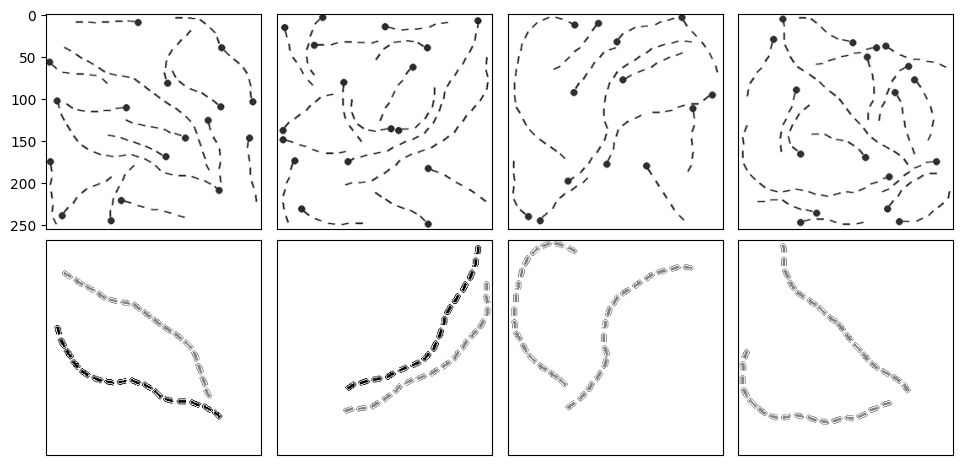

In [69]:
direc = '../../../../data/pathfinder_segmentation/pathfinder256_segmentation/'

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10,5))#, constrained_layout=True)
fig.tight_layout()

for col, i in enumerate([0,4,3,5]):
    with open(f'{direc}/imgs/30/sample_{i}.png', "rb") as f:
        sample = np.array(Image.open(f).convert("L"))  # Open in grayscale
    ax[0, col].imshow(sample, cmap='binary')
    ax[0, col].set_xticks([])
    if col > 0:
        ax[0, col].set_yticks([])
    
    main_segs = pickle.load(open(f"{direc}/paths/30/sample_{i}.pkl",'rb'))
    ax[1, col].imshow(get_output_mask(main_segs), cmap='binary', vmin=0, vmax=2)
    ax[1, col].set_xticks([])
    ax[1, col].set_yticks([])
    
fig.subplots_adjust(wspace=0., hspace=0.05)
# plt.savefig('../../../../misc/plots/pathfinder_segmentation_256.pdf', bbox_inches='tight')

In [70]:
mask = get_output_mask(main_segs) 
mask.dtype

torch.int64

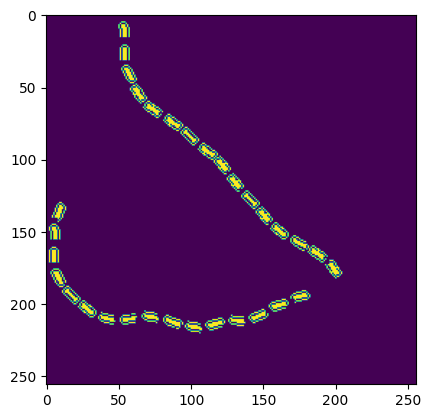

In [74]:
# y_true.shape
plt.imshow(mask)

In [84]:
for i, _y in enumerate(tqdm(y_true)):
    if (mask != _y).sum() < 4000:
        print(i, end='\n--\n')
        break

  0%|          | 0/900 [00:00<?, ?it/s]

0
--
